# CHAPTER6. 선형 회귀와 이웃 모델들


- 선형회귀, 부분최소제곱(PLS), 능형회귀(Ridge), 라쏘회귀(LASSO), 엘라스틱넷


- 목적 : 오차제곱합이나 오차제곱합 관련 함수의 최솟값을 만드는 변수의 추정값을 찾는 것


- 일반적인 선형 회귀에서는 최소 편향값을 가진 변수를 추정, 능형,라쏘,엘라스틱넷에서는 낮은 분산을 가진 추정값을 찾는다.

## 1. 사례 연구 : 구조적 정량 활성 관계 모델링

- 화합물의 화학적 특성에 대한 연구

- 1,267가지 화합물과 세 가지의 기술자 사용

    - 특정 세부 화학 구조의 존재 여부에 대해 280개의 이진수로 나타낸 "식별자"
    - 분자 결합 개수나 브롬 원자 개수 같은 16개의 숫자형 기술자
    - 분자 무게나 표면적 같은 4개의 연속형 기술자

In [2]:
install.packages("AppliedPredictiveModeling")
library(AppliedPredictiveModeling)
data(solubility)

also installing the dependency 'CORElearn'



package 'CORElearn' successfully unpacked and MD5 sums checked
package 'AppliedPredictiveModeling' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpEt9Obq\downloaded_packages


In [3]:
library(lattice)

### 데이터에 대한 몇가지 Plot 출력

- 분자 무게가 증가할수록 용해도는 일정하게 감소한다

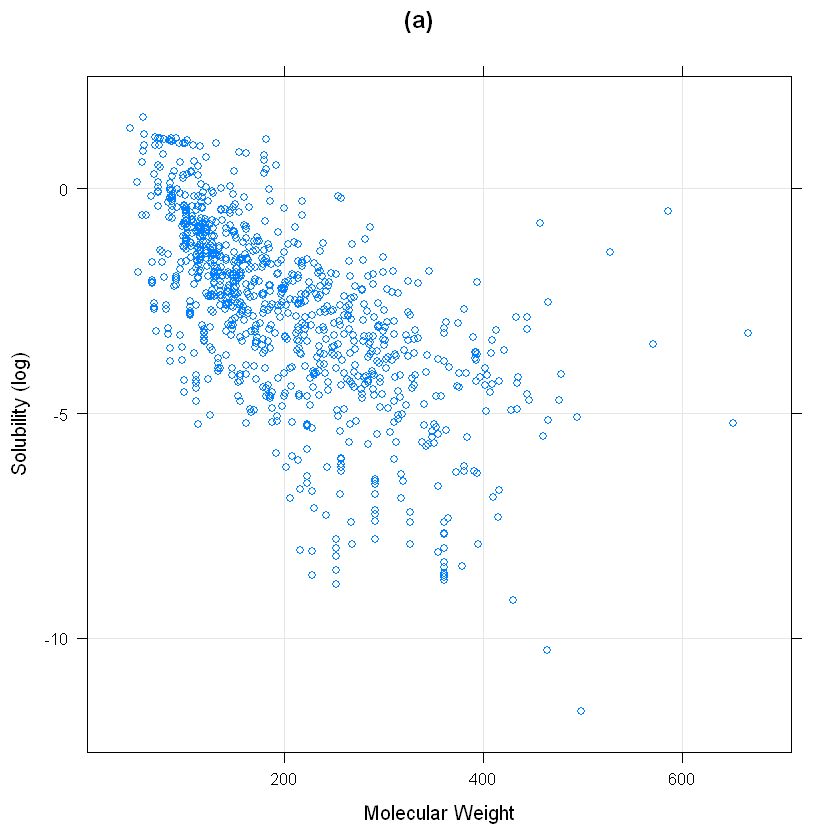

In [4]:
xyplot(solTrainY ~ solTrainX$MolWeight, type = c("p", "g"),
       ylab = "Solubility (log)",
       main = "(a)",
       xlab = "Molecular Weight")


- 분자에 특정 세부 구조가 없는 경우, 용해도가 약간 높다.

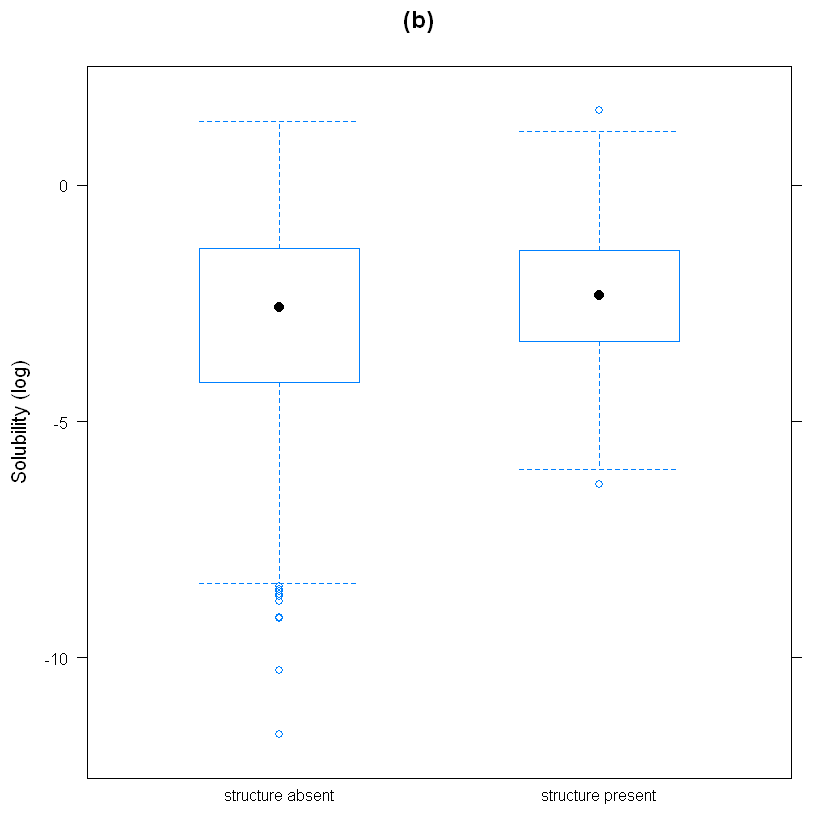

In [6]:
bwplot(solTrainY ~ ifelse(solTrainX[,100] == 1, 
                          "structure present", 
                          "structure absent"),
       ylab = "Solubility (log)",
       main = "(b)",
       horizontal = FALSE)


- 용해도 데이터 세트의 변형된 연속형 변수의 산점도

Loading required package: ggplot2
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"pseudoinverse used at -0.0059402"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"neighborhood radius 0.57302"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"reciprocal condition number  0"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"There are other near singularities as well. 0.32158"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"pseudoinverse used at -0.0059402"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"neighborhood radius 0.57302"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"reciprocal condition number  0"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"There are other near singularities as well

"at  -0.0024"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"radius  5.76e-006"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"all data on boundary of neighborhood. make span bigger"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"pseudoinverse used at -0.0024"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"neighborhood radius 0.0024"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"reciprocal condition number  1"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"zero-width neighborhood. make span bigger"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"at  -0.0024793"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"radius  6.1471e-006"Warning message in simpleLoess(y, x, w, span, degree = degree

"at  -0.0024793"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"radius  6.1471e-006"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"all data on boundary of neighborhood. make span bigger"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"pseudoinverse used at -0.0024793"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"neighborhood radius 0.0024793"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"reciprocal condition number  1"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE, :
"zero-width neighborhood. make span bigger"

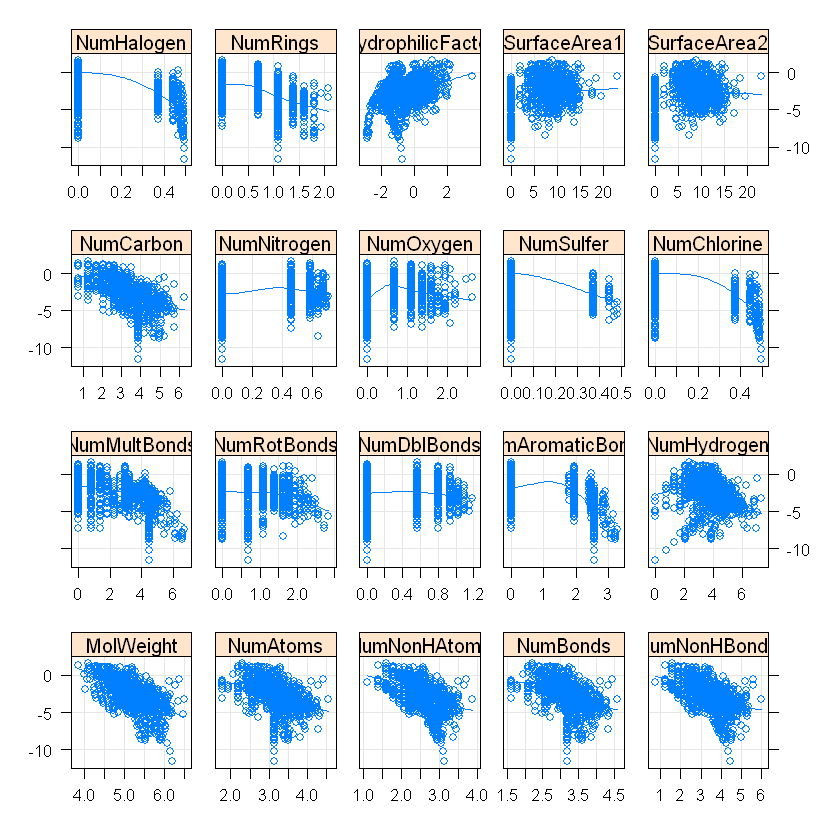

In [7]:
notFingerprints <- grep("FP", names(solTrainXtrans))

library(caret)
featurePlot(solTrainXtrans[, -notFingerprints],
            solTrainY,
            between = list(x = 1, y = 1),
            type = c("g", "p", "smooth"),
            labels = rep("", 2))

- 변환된 연속형 용해도 예측 변수의 변수 간 상관관계

In [9]:
install.packages("corrplot")
library(corrplot)

package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpEt9Obq\downloaded_packages


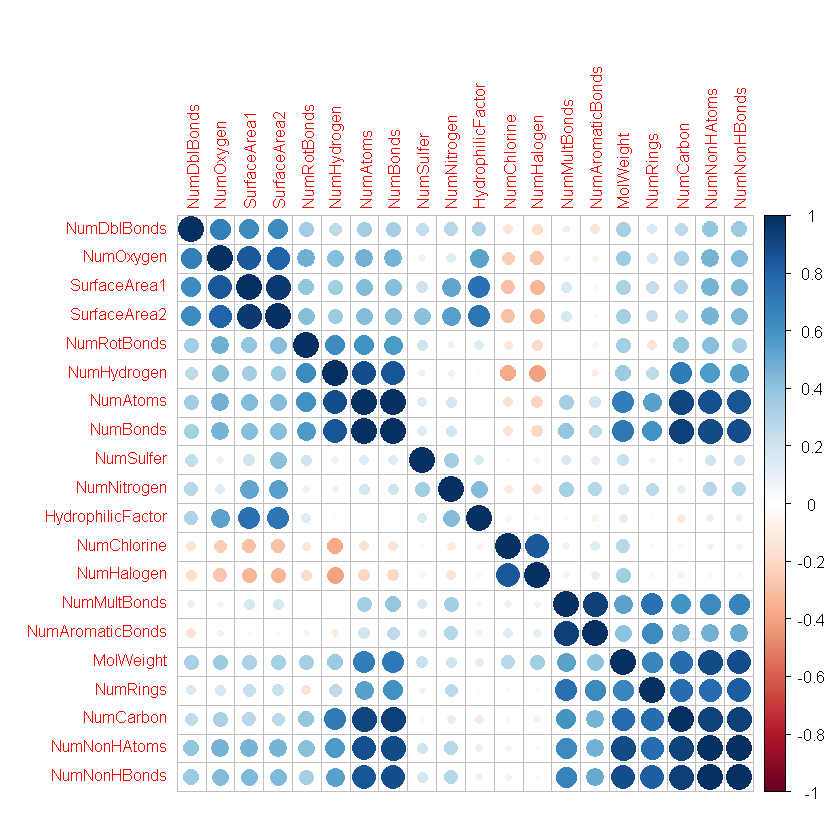

In [10]:
corrplot::corrplot(cor(solTrainXtrans[, -notFingerprints]), 
                   order = "hclust", 
                   tl.cex = .8)


## 2. 선형 회귀

- 관측값과 예측 응답값 간의 오차 제곱합(SSE)을 최소화하는 평면을 찾는 것


- 계수를 해석할 수 있는지 여부는 모델링의 도구로서 매우 유용하다.


- 서로 상관관계가 있는 예측 변수를 제거해 예측 변수의 수를 감소한다.


- 다중공선성을 판단할때는 분산팽창인수를 사용한다.


- 예측 변수의 수가 관측 수보다 크다면 PCA 처리가 하나의 처방이 될 수 있다.


- PLS, 능형회귀, 라소, 엘라스틱 넷 같이 인수 추정을 감소하는 방식도 가능하다.


- 결과로 나온 변수는 선형관계이므로 비선형 구조의 데이터에서는 성향을 파악할 수 없다.


- 대부분의 데이터가 포함된 전체 추세로부터 떨어져 있는 관측값을 좇아가려는 경향이 있다. 

    - 로버스트 회귀
    - SSE 대신 이상값에 덜 민감한 다른 지표 사용
    
- 원데이터 세트만이 아니라 모델 훈련과 평가에 사용된 데이터의 부분 집합을 갖고 사용할 때도 예측 변수가 관측치보다 크게 되선 안된다.


- 공선성을 해결하기 위해 변수를 제거하는 작업을 하지만, 특정 변수를 수동으로 제거하는 것이 쉽지 않다

    - 공선성에 영향을 받지 않을 수 있는 모델을 사용하는 것이 낫다
    
- 두 변수 간 강한 상관관계를 갖고 있는 예측 변수를 정의하고, 두 변수 간 상관관계의 절대값이 미리 정해 놓은 특정 정도를 넘어가는 경우 한쪽을 제거한다.

In [11]:
set.seed(100)
indx <- createFolds(solTrainY, returnTrain = TRUE)
ctrl <- trainControl(method = "cv", index = indx)

In [12]:
set.seed(100)
lmTune0 <- train(x = solTrainXtrans, y = solTrainY,
                method = "lm",
                 trControl = ctrl)

lmTune0                 

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

Linear Regression 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.7210355  0.8768359  0.5401102

Tuning parameter 'intercept' was held constant at a value of TRUE

- Correlation이 높은 변수를 제거하기 위한 Filtering 작업

In [13]:
tooHigh <- findCorrelation(cor(solTrainXtrans), .9)
trainXfiltered <- solTrainXtrans[, -tooHigh]
testXfiltered  <-  solTestXtrans[, -tooHigh]

set.seed(100)
lmTune <- train(x = trainXfiltered, y = solTrainY,
                method = "lm",
                trControl = ctrl)

lmTune

Linear Regression 

951 samples
190 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.7113935  0.8793396  0.5410503

Tuning parameter 'intercept' was held constant at a value of TRUE

In [14]:
testResults <- data.frame(obs = solTestY,
                          Linear_Regression = predict(lmTune, testXfiltered))

## 3. 부분 최소 제곱

- 예측 변수 간의 상관관계가 높은 경우

    - 높은 상관관계의 예측 변수를 제거
                
    - PCA 적용(트레이드 오프 : 새 변수를 실제로 이해하기 힘들다)
        
    - PCR(Principal Component Regression) : PCA를 통한 차원 축소로 (최대 변동성을 가진) 새로운 예측 변수를 생성해 회귀 모형 생성    
    
    - PCA는 성분 선택에 있어서 응답 변수에 대해 어떤 측면도 고려하지 않는다.
        
    - PCR은 변동성이 응답 변수와 연관이 있는 경우 유용하다
    
    - 상관 관계가 있는 예측 변수가 있고, 선형 회귀 형태의 해답이 필요한 경우에는 PLS(부분최소제곱)이 유용하다.
    
    - PCA 선형 조합이 예측 변수 공간의 변동성을 최대로 하는 값을 선택한다면, 예측 변수의 PLS 선형 조합은 응답 변수의 공분산을 최대로 하는 값을 고르게 된다. 
    
    - PLS는 예측 변수 공간 차원 축소, 예측 변수, 응답 변수의 관계라는 목적간의 합의점을 찾아야 한다.
    
    - PLS는 **지도차원축소 과정**으로 볼 수 있고, PCR은 **비지도 과정**으로 볼 수 있다.
    
    - PLS는 응답 변수와의 회귀를 위한 최적의 예측 공간 차원 축소를 구한다.

- PLS 사용했을 때 10개 성분일 때 최소 RMSE(0.682)

In [17]:
install.packages("pls")

set.seed(100)
plsTune <- train(x = solTrainXtrans, y = solTrainY,
                 method = "pls",
                 tuneGrid = expand.grid(ncomp = 1:20),
                 trControl = ctrl)
plsTune

package 'pls' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpEt9Obq\downloaded_packages


Partial Least Squares 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared   MAE      
   1     1.7543811  0.2630495  1.4358231
   2     1.2720647  0.6128490  0.9889055
   3     1.0373646  0.7432147  0.8052678
   4     0.8370618  0.8317217  0.6386385
   5     0.7458318  0.8660461  0.5714998
   6     0.7106591  0.8779019  0.5490473
   7     0.6921293  0.8841448  0.5323473
   8     0.6908481  0.8851647  0.5315022
   9     0.6828771  0.8877056  0.5243122
  10     0.6824521  0.8879195  0.5239849
  11     0.6826719  0.8878955  0.5259022
  12     0.6847473  0.8872488  0.5197999
  13     0.6836698  0.8875568  0.5234800
  14     0.6856134  0.8871389  0.5237689
  15     0.6867190  0.8869351  0.5245770
  16     0.6860797  0.8872705  0.5244890
  17     0.6881636  0.8866078  0.5245726
  18     0.6926077  0.8853743  0.5256957
  19  

- PCR 사용했을 때 35개의 성분일 때 최소 RMSE(0.73)

In [18]:
testResults$PLS <- predict(plsTune, solTestXtrans)

set.seed(100)
pcrTune <- train(x = solTrainXtrans, y = solTrainY,
                 method = "pcr",
                 tuneGrid = expand.grid(ncomp = 1:35),
                 trControl = ctrl)
pcrTune                  

Principal Component Analysis 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared    MAE      
   1     1.9778920  0.06590758  1.5840621
   2     1.6379400  0.36202127  1.2815335
   3     1.3655645  0.55546442  1.0612359
   4     1.3715028  0.55157507  1.0642859
   5     1.3415864  0.57099834  1.0311280
   6     1.2081745  0.64973828  0.9246561
   7     1.1818622  0.66578017  0.8975892
   8     1.1452119  0.68759737  0.8767988
   9     1.0495852  0.73655117  0.8203592
  10     1.0063822  0.75723962  0.7797613
  11     0.9723334  0.77443568  0.7486139
  12     0.9692845  0.77566291  0.7467677
  13     0.9526792  0.78316647  0.7388066
  14     0.9396590  0.78895459  0.7303651
  15     0.9419390  0.78796957  0.7324749
  16     0.8695211  0.81842614  0.6643545
  17     0.8699482  0.81825536  0.6641582
  18     0.8719274  0.

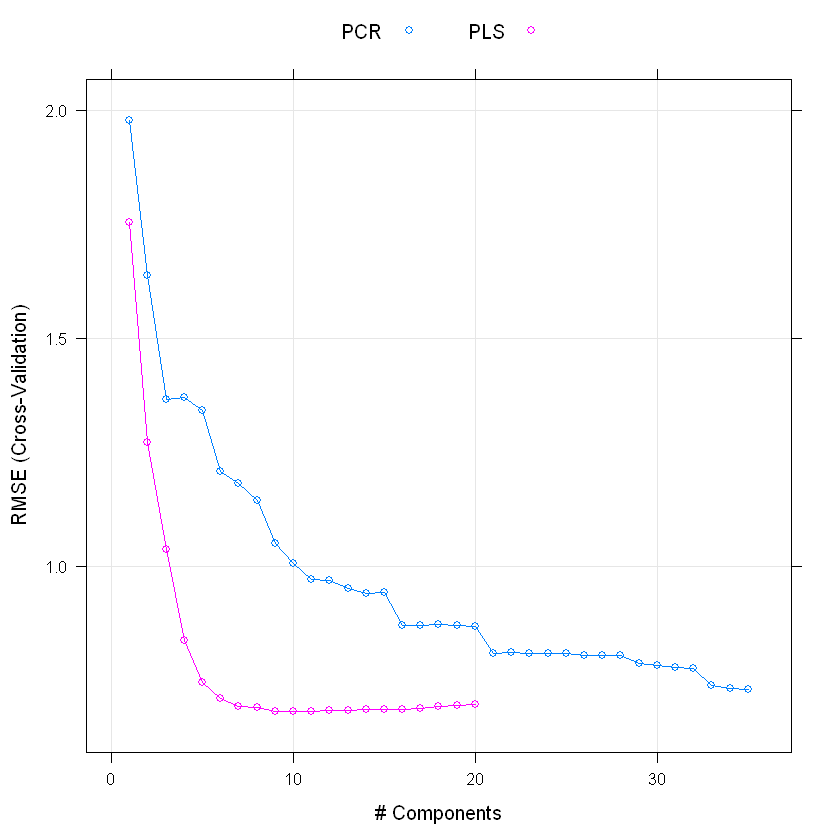

In [19]:

plsResamples <- plsTune$results
plsResamples$Model <- "PLS"
pcrResamples <- pcrTune$results
pcrResamples$Model <- "PCR"
plsPlotData <- rbind(plsResamples, pcrResamples)

xyplot(RMSE ~ ncomp,
       data = plsPlotData,
       #aspect = 1,
       xlab = "# Components",
       ylab = "RMSE (Cross-Validation)",
       auto.key = list(columns = 2),
       groups = Model,
       type = c("o", "g"))

## 4. 벌점 모델

- 편향성이 증가하면 분산이 작아진다.

- 예측 변수 간의 상관계수가 큰 경우, 분산이 매우 커진다.

- 편향적인 모델로 인해 발생하는 공선성 문제를 해결하면 총 MSE가 좋은 회귀 모델을 구축할 수 있다.

- 편향적 회귀 모델을 만드는 한가지 방법은 **오차 제곱 합에 벌점을 부과** 하는 것이다.

- 벌점은 SSE가 감소하는 경우에만 인수 추정값이 더 커질 수 있도록 하는 효과를 낸다.

- 벌점을 부과하는 방식 -> **분산과 편향 간의 트레이드 오프**

- 편향성을 약간 희생해 분산을 축소시켜 비편향 모델에 비해 전체 MSE가 낮아지도록 한다.

- 벌점이 커지면 인수 추정값은 서로 다른 속도로 0에 수렴하게 된다.

### Ridge 회귀 (능형 회귀)

- 회귀 계수를 0에 가깝게 축소시키지만 0이 되지는 않는다. (특징 선택을 하지 않는다.)

- L2 정규화식을 사용한다.

### LASSO 회귀

- 회귀 계수를 정확히 0이 되게 축소시킨다 (특징 선택을 한다.)

- L1 정규화식을 사용한다.

In [23]:
install.packages("elasticnet")

also installing the dependency 'lars'



package 'lars' successfully unpacked and MD5 sums checked
package 'elasticnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\student\AppData\Local\Temp\RtmpEt9Obq\downloaded_packages


In [24]:
ridgeGrid <- expand.grid(lambda = seq(0, .1, length = 15))

set.seed(100)
ridgeTune <- train(x = solTrainXtrans, y = solTrainY,
                   method = "ridge",
                   tuneGrid = ridgeGrid,
                   trControl = ctrl,
                   preProc = c("center", "scale"))
ridgeTune

Ridge Regression 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  lambda       RMSE       Rsquared   MAE      
  0.000000000  0.7353938  0.8724201  0.5440849
  0.007142857  0.7047552  0.8818659  0.5352468
  0.014285714  0.6964731  0.8847911  0.5298526
  0.021428571  0.6925923  0.8862699  0.5270496
  0.028571429  0.6908607  0.8870609  0.5260082
  0.035714286  0.6904220  0.8874561  0.5260650
  0.042857143  0.6908596  0.8875983  0.5267406
  0.050000000  0.6919152  0.8875759  0.5277925
  0.057142857  0.6934719  0.8874300  0.5291986
  0.064285714  0.6954114  0.8872009  0.5308565
  0.071428571  0.6976723  0.8869096  0.5327291
  0.078571429  0.7002069  0.8865723  0.5347215
  0.085714286  0.7029801  0.8862009  0.5368744
  0.092857143  0.7059656  0.8858041  0.5391389
  0.100000000  0.7091432  0.8853885  0.5415401

RMSE was 

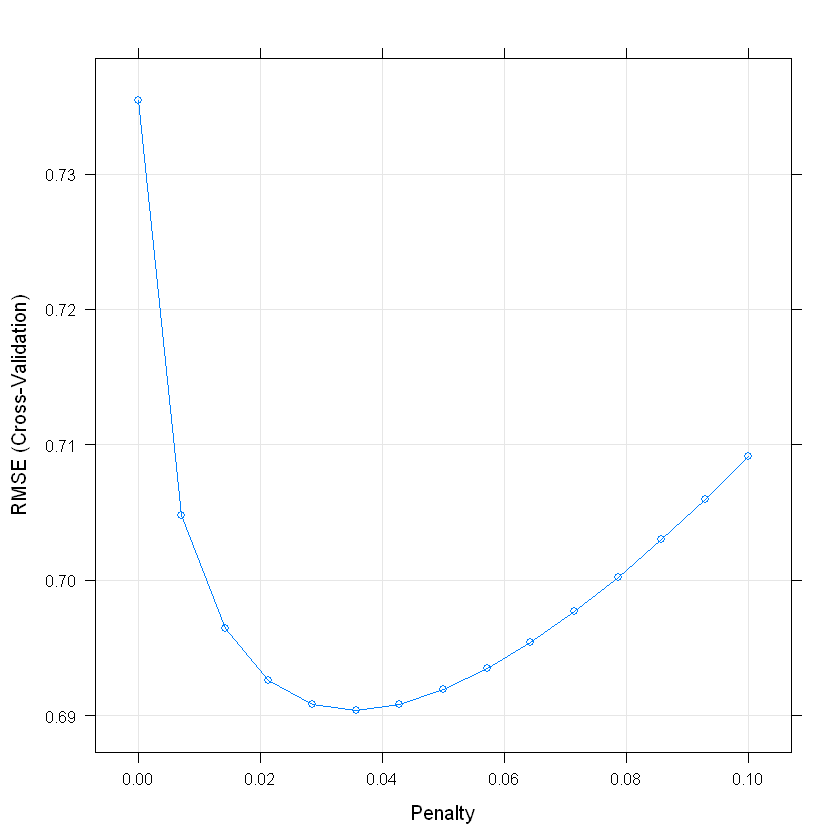

In [25]:
print(update(plot(ridgeTune), xlab = "Penalty"))

- 최소 각도 회귀 (Least Angle Regression, LARS) : 고차원 문제에 있어서 라소 모델을 보다 효과적으로 최적화 하는데 쓰일 수 있다.

- 엘라스틱 넷 (Elastic Net) : 릿지 회귀와 라소 회귀를 조합한 모형

In [26]:
enetGrid <- expand.grid(lambda = c(0, 0.01, .1), 
                        fraction = seq(.05, 1, length = 20))
set.seed(100)
enetTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "enet",
                  tuneGrid = enetGrid,
                  trControl = ctrl,
                  preProc = c("center", "scale"))
enetTune

Elasticnet 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared   MAE      
  0.00    0.05      0.8697668  0.8339704  0.6591917
  0.00    0.10      0.6876406  0.8860368  0.5230357
  0.00    0.15      0.6728555  0.8908176  0.5134961
  0.00    0.20      0.6753400  0.8904234  0.5164444
  0.00    0.25      0.6878960  0.8865271  0.5250011
  0.00    0.30      0.6971510  0.8836300  0.5305780
  0.00    0.35      0.7063341  0.8808159  0.5354825
  0.00    0.40      0.7128053  0.8788310  0.5388954
  0.00    0.45      0.7137702  0.8785880  0.5393015
  0.00    0.50      0.7140577  0.8785796  0.5392972
  0.00    0.55      0.7143832  0.8785180  0.5391753
  0.00    0.60      0.7138485  0.8787158  0.5384255
  0.00    0.65      0.7139301  0.8787247  0.5379541
  0.00    0.70      0.7144253  0.8786094

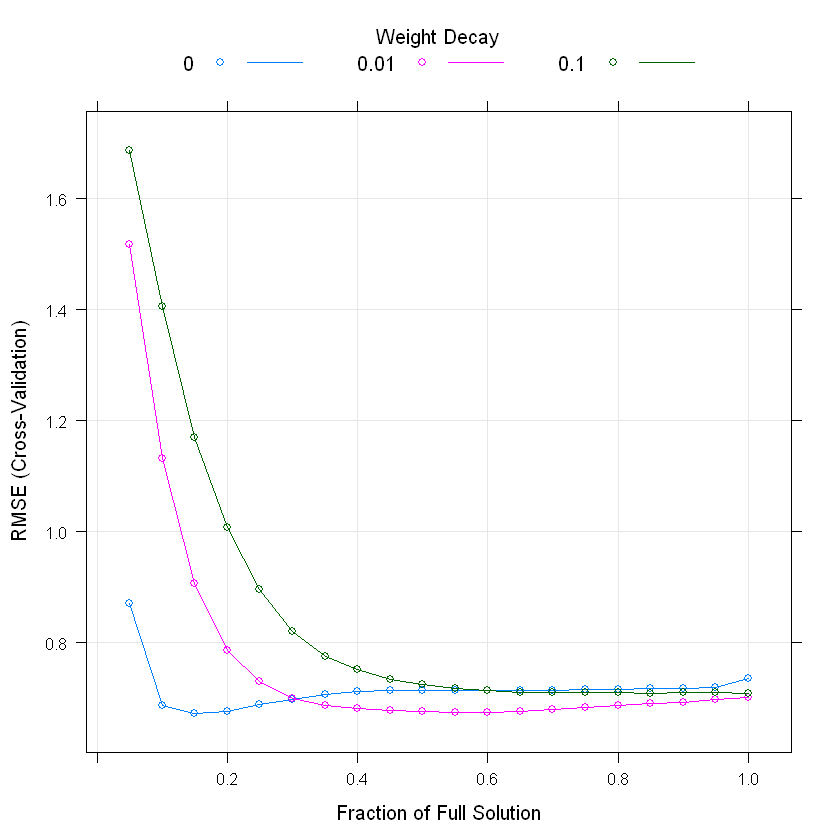

In [27]:
plot(enetTune)